In [1]:
import ee
import geemap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from geemap import ml
from sklearn import ensemble

In [4]:
#ee.Authenticate()
ee.Initialize()

In [5]:
Map = geemap.Map(center=[-74.05,0.9], zoom= 8)

In [6]:
Map = geemap.Map(basemap='HYBRID')

In [33]:
Map.add_basemap('OpenTopoMap')

In [7]:
Map.add_basemap('Esri.WorldImagery')

In [35]:
Map.add_basemap('Gaode.Satellite')

In [8]:
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# <font style="color:red">1. Colecciones y ROI </font>

In [9]:
roi =ee.Feature(
    ee.Geometry.Polygon([
        [[-74.481355,0.932196],
              [-74.481355,0.631389],
              [-74.412,0.631389],
              [-74.412,0.932196]]
    ]),
        {
          "area": "chiribiquete",
          "system:index": "0"
        })

In [10]:
#Visualizar la región de interés
Map.addLayer(roi,{},"roi")

In [11]:
#Colección de imagenes landsat 8
Imagenes = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterMetadata('CLOUD_COVER','less_than',30)
)

# <font style="color:green">1.1 Enmascarar nubes </font>

In [12]:
#Enmascaramiento de nubes
def maskL8sr(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 4)
    qa = img.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return img.updateMask(mask)

In [13]:
Imagenes_sinNubes = Imagenes.map(maskL8sr)

# <font style="color:green">1.2 Cortar imagenes </font>

In [14]:
#Cortar imagenes
def cortar(img):
    return img.clip(roi).copyProperties(img,["system:time_start"])

In [15]:
Imagenes_cortadas = Imagenes_sinNubes.map(cortar)

# <font style="color:green">1.3 Crear NDVI </font>

In [16]:
def toNDVI8(img):
    ndvi = img.expression('((NIR - RED) / (NIR + RED))',
    {'NIR': img.select('SR_B5'),
    'RED': img.select('SR_B4')}).rename('NDVI').copyProperties(img, ['system:time_start'])
    return img.addBands(ndvi)

In [17]:
Imagenes_cortadas = Imagenes_cortadas.map(toNDVI8)

# <font style="color:green">1.4 Crear imagenes promedio anuales </font>

In [18]:
# Imagenes promedio por años
LS2014 = Imagenes_cortadas.filterDate("2014-01-01","2014-12-31").mean()
LS2015 = Imagenes_cortadas.filterDate("2015-01-01","2015-12-31").mean()
LS2016 = Imagenes_cortadas.filterDate("2016-01-01","2016-12-31").mean()
LS2017 = Imagenes_cortadas.filterDate("2017-01-01","2017-12-31").mean()
LS2018 = Imagenes_cortadas.filterDate("2018-01-01","2018-12-31").mean()
LS2019 = Imagenes_cortadas.filterDate("2019-01-01","2019-12-31").mean()
LS2020 = Imagenes_cortadas.filterDate("2020-01-01","2020-12-31").mean()
LS2021 = Imagenes_cortadas.filterDate("2021-01-01","2021-12-31").mean()
LS2022 = Imagenes_cortadas.filterDate("2022-01-01","2022-12-31").mean()

# <font style="color:green">1.5 Mostrar promedio anuales </font>

In [19]:
# Imprimir el resultado en el visor
Map.addLayer(LS2014.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2014")
Map.addLayer(LS2015.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2015")
Map.addLayer(LS2016.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2016")
Map.addLayer(LS2017.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2017")
Map.addLayer(LS2018.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2018")
Map.addLayer(LS2019.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2019")
Map.addLayer(LS2020.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2020")
Map.addLayer(LS2021.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2021")
Map.addLayer(LS2022.select(["SR_B4","SR_B3","SR_B2"]), {"min":8256.6, "max":9647.4}, "2022")

# <font style="color:red">2. SELECCIÓN DE PUNTOS DE ENTRENAMIENTO </font>

# <font style="color:green">2.1 Año 2022 </font>

In [20]:
paleta = ['#8000ff', ' #7e03ff', ' #7c06ff', ' #7a09ff', ' #780dff', ' #7610ff', ' #7413ff', ' #7216ff', ' #7019ff', ' #6e1cff', ' #6c1fff', ' #6a22fe', ' #6826fe', ' #6629fe', ' #642cfe', ' #622ffe', ' #6032fe', ' #5e35fe', ' #5c38fd', ' #5a3bfd', ' #583efd', ' #5641fd', ' #5444fd', ' #5247fc', ' #504afc', ' #4e4dfc', ' #4c50fc', ' #4a53fb', ' #4856fb', ' #4659fb', ' #445cfb', ' #425ffa', ' #4062fa', ' #3e65fa', ' #3c68f9', ' #396bf9', ' #386df9', ' #3670f8', ' #3473f8', ' #3176f8', ' #3079f7', ' #2e7bf7', ' #2c7ef7', ' #2981f6', ' #2884f6', ' #2686f5', ' #2489f5', ' #218cf4', ' #208ef4', ' #1e91f3', ' #1c93f3', ' #1996f3', ' #1898f2', ' #169bf2', ' #149df1', ' #11a0f1', ' #10a2f0', ' #0ea5ef', ' #0ca7ef', ' #09a9ee', ' #08acee', ' #06aeed', ' #04b0ed', ' #01b3ec', ' #00b5eb', ' #02b7eb', ' #04b9ea', ' #07bbea', ' #08bee9', ' #0ac0e8', ' #0dc2e8', ' #0fc4e7', ' #10c6e6', ' #12c8e6', ' #14cae5', ' #17cbe4', ' #18cde4', ' #1acfe3', ' #1dd1e2', ' #1fd3e1', ' #20d5e1', ' #22d6e0', ' #24d8df', ' #27dade', ' #28dbde', ' #2adddd', ' #2ddedc', ' #2fe0db', ' #30e1da', ' #32e3da', ' #34e4d9', ' #37e6d8', ' #38e7d7', ' #3ae8d6', ' #3dead5', ' #3febd5', ' #40ecd4', ' #42edd3', ' #44eed2', ' #46efd1', ' #48f1d0', ' #4af2cf', ' #4df3ce', ' #4ef3cd', ' #50f4cc', ' #52f5cb', ' #54f6cb', ' #56f7ca', ' #58f8c9', ' #5af8c8', ' #5df9c7', ' #5efac6', ' #60fac5', ' #62fbc4', ' #64fbc3', ' #66fcc2', ' #68fcc1', ' #6afdc0', ' #6dfdbf', ' #6efebe', ' #70febc', ' #72febb', ' #74feba', ' #76ffb9', ' #78ffb8', ' #7affb7', ' #7dffb6', ' #7effb5', ' #80ffb4', ' #82ffb3', ' #84ffb2', ' #86ffb0', ' #88ffaf', ' #8bfeae', ' #8cfead', ' #8efeac', ' #90feab', ' #92fda9', ' #94fda8', ' #96fca7', ' #99fca6', ' #9bfba5', ' #9cfba4', ' #9efaa2', ' #a0faa1', ' #a2f9a0', ' #a4f89f', ' #a6f89d', ' #a8f79c', ' #abf69b', ' #acf59a', ' #aef498', ' #b0f397', ' #b2f396', ' #b4f295', ' #b6f193', ' #b9ef92', ' #bbee91', ' #bced8f', ' #beec8e', ' #c0eb8d', ' #c2ea8c', ' #c4e88a', ' #c6e789', ' #c8e688', ' #cbe486', ' #cce385', ' #cee184', ' #d0e082', ' #d2de81', ' #d4dd80', ' #d6db7e', ' #d9da7d', ' #dbd87b', ' #dcd67a', ' #ded579', ' #e0d377', ' #e2d176', ' #e4cf74', ' #e6cd73', ' #e8cb72', ' #ebca70', ' #ecc86f', ' #eec66d', ' #f0c46c', ' #f2c26b', ' #f4c069', ' #f6be68', ' #f9bb66', ' #fbb965', ' #fcb763', ' #feb562', ' #ffb360', ' #ffb05f', ' #ffae5e', ' #ffac5c', ' #ffa95b', ' #ffa759', ' #ffa558', ' #ffa256', ' #ffa055', ' #ff9d53', ' #ff9b52', ' #ff9850', ' #ff964f', ' #ff934d', ' #ff914c', ' #ff8e4a', ' #ff8c49', ' #ff8947', ' #ff8646', ' #ff8444', ' #ff8143', ' #ff7e41', ' #ff7b40', ' #ff793e', ' #ff763d', ' #ff733b', ' #ff703a', ' #ff6d38', ' #ff6b37', ' #ff6835', ' #ff6533', ' #ff6232', ' #ff5f30', ' #ff5c2f', ' #ff592d', ' #ff562c', ' #ff532a', ' #ff5029', ' #ff4d27', ' #ff4a26', ' #ff4724', ' #ff4422', ' #ff4121', ' #ff3e1f', ' #ff3b1e', ' #ff381c', ' #ff351b', ' #ff3219', ' #ff2f18', ' #ff2c16', ' #ff2914', ' #ff2613', ' #ff2211', ' #ff1f10', ' #ff1c0e', ' #ff190d', ' #ff160b', ' #ff1309', ' #ff1008', ' #ff0d06', ' #ff0905', ' #ff0603', ' #ff0302', ' #ff0000']

In [21]:
Map.addLayer(LS2022.select("NDVI"), {"min":0.2, "max":0.4, 'palette':paleta}, "NDVI 2014")

In [26]:
Map

Map(bottom=8358454.0, center=[0.6534577799670713, -74.45564389228822], controls=(WidgetControl(options=['posit…

# <font style="color:blue">2.1.1 En esta opción vamos a traer los puntos que marquemos del visor </font>

In [22]:
#Nota: seleccionar primero los puntos en el visor y luego correr la linea
#Sin vegetación año 2014
SV2014 = ee.FeatureCollection(Map.draw_features)

In [23]:
SV2014

In [24]:
SV2014 = SV2014.map(lambda feature: feature.set('zona', 0))

In [25]:
SV2014

In [27]:
# Ahora vamos a seleccionar los punto que corresponden a la vegetación
# Nota: en la opción "delete layers" del visor borren los puntos de la clase pasada para empezar una nueva
CV2014 = ee.FeatureCollection(Map.draw_features)

In [28]:
CV2014

In [29]:
CV2014 = CV2014.map(lambda feature: feature.set('zona', 1))

In [30]:
CV2014

In [31]:
#Ahora vamos a unificar las dos clases que hemos creado en una sola colección
#Entrenamiento2014 =  ee.FeatureCollection(ee.List([SV2014,CV2014]))
#Entrenamiento2014 =  SV2014.merge(CV2014)
Entrenamiento2014 =  SV2014.merge(CV2014)

In [32]:
Entrenamiento2014

In [33]:
#Podemos revisar la primera colección "SV" empleando algunas de las propiedades que les asignamos
Entrenamiento2014.filter(ee.Filter.eq('zona',0))

In [34]:
#Podemos revisar la primera colección "SV" empleando algunas de las propiedades que les asignamos
Entrenamiento2014.filter(ee.Filter.eq('zona',1))

In [36]:
# En esta opción podemos guardar nuestros datos de entrenamiento como un archivo .shp
geemap.ee_to_shp(Entrenamiento2014, "DatosEntrenamientoRF_2022.shp")

Generating URL ...
Please wait ...
Data downloaded to c:\Users\ingju\OneDrive\Documentos\GitHub\MGITG\GeoAI\Análisis_Nevados\GeoAI\DatosEntrenamientoRF_2022.shp


# <font style="color:green">2.2 Bandas empleadas para la predicción </font>

In [25]:
bandas = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','NDVI']

In [26]:
#Etique que contiene las propiedades de los puntos creados
etiqueta = "zona"

# <font style="color:red">3. ENTRENAMIENTO </font>

In [47]:
# https://developers.google.com/earth-engine/apidocs/ee-classifier-smilerandomforest#colab-python

# https://geemap.org/notebooks/32_supervised_classification/#add-a-legend-to-the-map

# https://www.youtube.com/playlist?list=PLLJHvBcuQLfWGHaUgtWYPu4mcyT6Wl3WR

In [39]:
entrenamiento = LS2022.select(bandas).sampleRegions(
    **{'collection': Entrenamiento2014, 'properties': [etiqueta], 'scale': 30}
)

In [40]:
entrenamiento

In [41]:
print(entrenamiento.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '1_0_0', 'properties': {'NDVI': 0.33881017565727234, 'SR_B1': 8879, 'SR_B2': 9074, 'SR_B3': 10192.333333333334, 'SR_B4': 9989, 'SR_B5': 20305.333333333332, 'SR_B6': 17403.666666666668, 'SR_B7': 12523.666666666666, 'zona': 0}}


In [42]:
#Vamos a emplear Random Forest
#Opciones: numberOfTrees, variablesPerSplit, minLeafPopulation, bagFraction, maxNodes, seed

#numberOfTrees	Número de árboles a crear (número entero)
#variablesPerSplit	por defecto: nulo	El número de variables por división. Si no se especifica, utiliza la raíz cuadrada del número de variables.(entero)
#minLeafPopulation	por defecto: 1	Cree únicamente nodos cuyo conjunto de entrenamiento contenga al menos esta cantidad de puntos (entero)
#bagFraction	por defecto: 0.5	TLa fracción de entrada al bag por árbol (flotante)
#maxNodes	por defecto: nulo	El número máximo de nodos de hojas en cada árbol. Si no se especifica, el valor predeterminado es sin límite (entero)
#seed	por defecto: 0	La semilla de la aleatorización (entero)

DatosEntrenados = ee.Classifier.smileRandomForest(**{"numberOfTrees":100}).train(entrenamiento, etiqueta, bandas)

In [43]:
# Información de los datos entrenados por el clasificador
display('Resultados del entrenamiento con RF', DatosEntrenados.explain())

'Resultados del entrenamiento con RF'

In [44]:
ExactitudEntrenamiento = DatosEntrenados.confusionMatrix()

In [45]:
display('Matriz de confusión', ExactitudEntrenamiento)

'Matriz de confusión'

In [46]:
display('Exactitud general del entrenamiento', ExactitudEntrenamiento.accuracy())

'Exactitud general del entrenamiento'

# <font style="color:red">4. CLASIFICACIÓN </font>

In [48]:
resultados

In [49]:
Map.addLayer(resultados.randomVisualizer(), {}, 'coverturas 2014')

In [50]:
Map

Map(bottom=8358399.0, center=[0.6546378750410355, -74.44714665412904], controls=(WidgetControl(options=['posit…

# <font style="color:red">5. CALCULAR ÁREAS </font>

In [51]:
#Área de mi poligono en km^2

roi.area().divide(1000000)

In [75]:
resultados = LS2022.select(bandas).classify(EntrenamientoRF)

In [76]:
#Área clasificada como deforestada (0) y con vegetación (1) en km^2

df = geemap.image_area_by_group(
    resultados, scale=1000, denominator=1e6, decimal_places=4, verbose=True
)
df

Calculating area for group 0 ...
Calculating area for group 1 ...


,area,percentage
group,,
0,18.4662,0.0719
1,238.2155,0.9281


In [78]:
238.2155-208.4148

29.800699999999978

# <font style="color:red">6. REALIZAR RF CON LOS DATOS DE ENTRENAMIENTO DESCARGADOS </font>

In [22]:
PuntoEntrenamiento = geemap.shp_to_ee("DatosEntrenamientoRF_2022.shp")

In [23]:
PuntoEntrenamiento

In [47]:
Muestraentrenamiento = LS2022.select(bandas).sampleRegions(
    **{'collection': PuntoEntrenamiento, 'properties': [etiqueta], 'scale': 30}
)

In [48]:
print(Muestraentrenamiento.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'NDVI': 0.2577095329761505, 'SR_B1': 8795.533333333333, 'SR_B2': 9097.533333333333, 'SR_B3': 10177.533333333333, 'SR_B4': 10443, 'SR_B5': 17828.533333333333, 'SR_B6': 17785.133333333335, 'SR_B7': 13246.2, 'zona': 0}}


In [49]:
#Vamos a tomar una muestra de cada clase de los puntos de entrenamiento que creamos

muestra = Muestraentrenamiento.randomColumn() #Entre más puntos de entrenamiento tengamos es mejor

In [50]:
muestraEntrenamiento = muestra.filter('random <= 0.8') #Tomamos el 80% de los datos para entrenar el modelo

In [51]:
muestraValidacion = muestra.filter('random > 0.8') #Tomamos el 20% de los datos para validar el modelo

In [52]:
muestraEntrenamiento

In [53]:
muestraValidacion

In [54]:
# Entrenar el clasificador con 10 árboles

EntrenamientoRF = ee.Classifier.smileRandomForest(**{"numberOfTrees":10}).train(muestraEntrenamiento,etiqueta,bandas)

In [55]:
#Proyectamos los resultados del entrenamiento para el modelo RF

display('Resultados del entrenamiento', EntrenamientoRF.explain())

'Resultados del entrenamiento'

In [56]:
#Matriz de confusión del entrenamiento

exactitudEntrenamiento = EntrenamientoRF.confusionMatrix()

In [57]:
display('Matriz de confusión del entrenamiento', exactitudEntrenamiento)

'Matriz de confusión del entrenamiento'

In [58]:
display('Exactitud global del entrenamiento', exactitudEntrenamiento.accuracy())

'Exactitud global del entrenamiento'

In [59]:
# Ahora vamos a realizar la validación, esto se hace ya con los datos entrenados

validacionDeDatos = muestraValidacion.classify(EntrenamientoRF)

In [60]:
exactitudValidacion = validacionDeDatos.errorMatrix(etiqueta, 'classification')

In [61]:
display('Matriz de confusión de la validacion', exactitudValidacion)

'Matriz de confusión de la validacion'

In [62]:
display('Exactitud de la validación', exactitudValidacion.accuracy())

'Exactitud de la validación'

In [65]:
#Vamos a clasificar nuevamente nuestra imagen

img_clasificada_2014 = LS2022.select(bandas).classify(EntrenamientoRF)

In [66]:
img_clasificada_2014

In [67]:
Map.addLayer(img_clasificada_2014.select("classification"), {}, 'coverturas 2014 segunda prueba')

In [68]:
Map

Map(bottom=261315.0, center=[0.7751991265755049, -74.34551239013673], controls=(WidgetControl(options=['positi…

In [69]:
geemap.ee_export_image(img_clasificada_2014,"Cobertura2022.tif",scale=30,crs=None,crs_transform=None,region=ee.Geometry.Polygon([
    [[-74.481355,0.932196],
    [-74.481355,0.631389],
    [-74.412,0.631389],
    [-74.412,0.932196]]
]),dimensions=None,file_per_band=False,)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\ingju\OneDrive\Documentos\GitHub\MGITG\GeoAI\Análisis_Nevados\GeoAI\Cobertura2022.tif


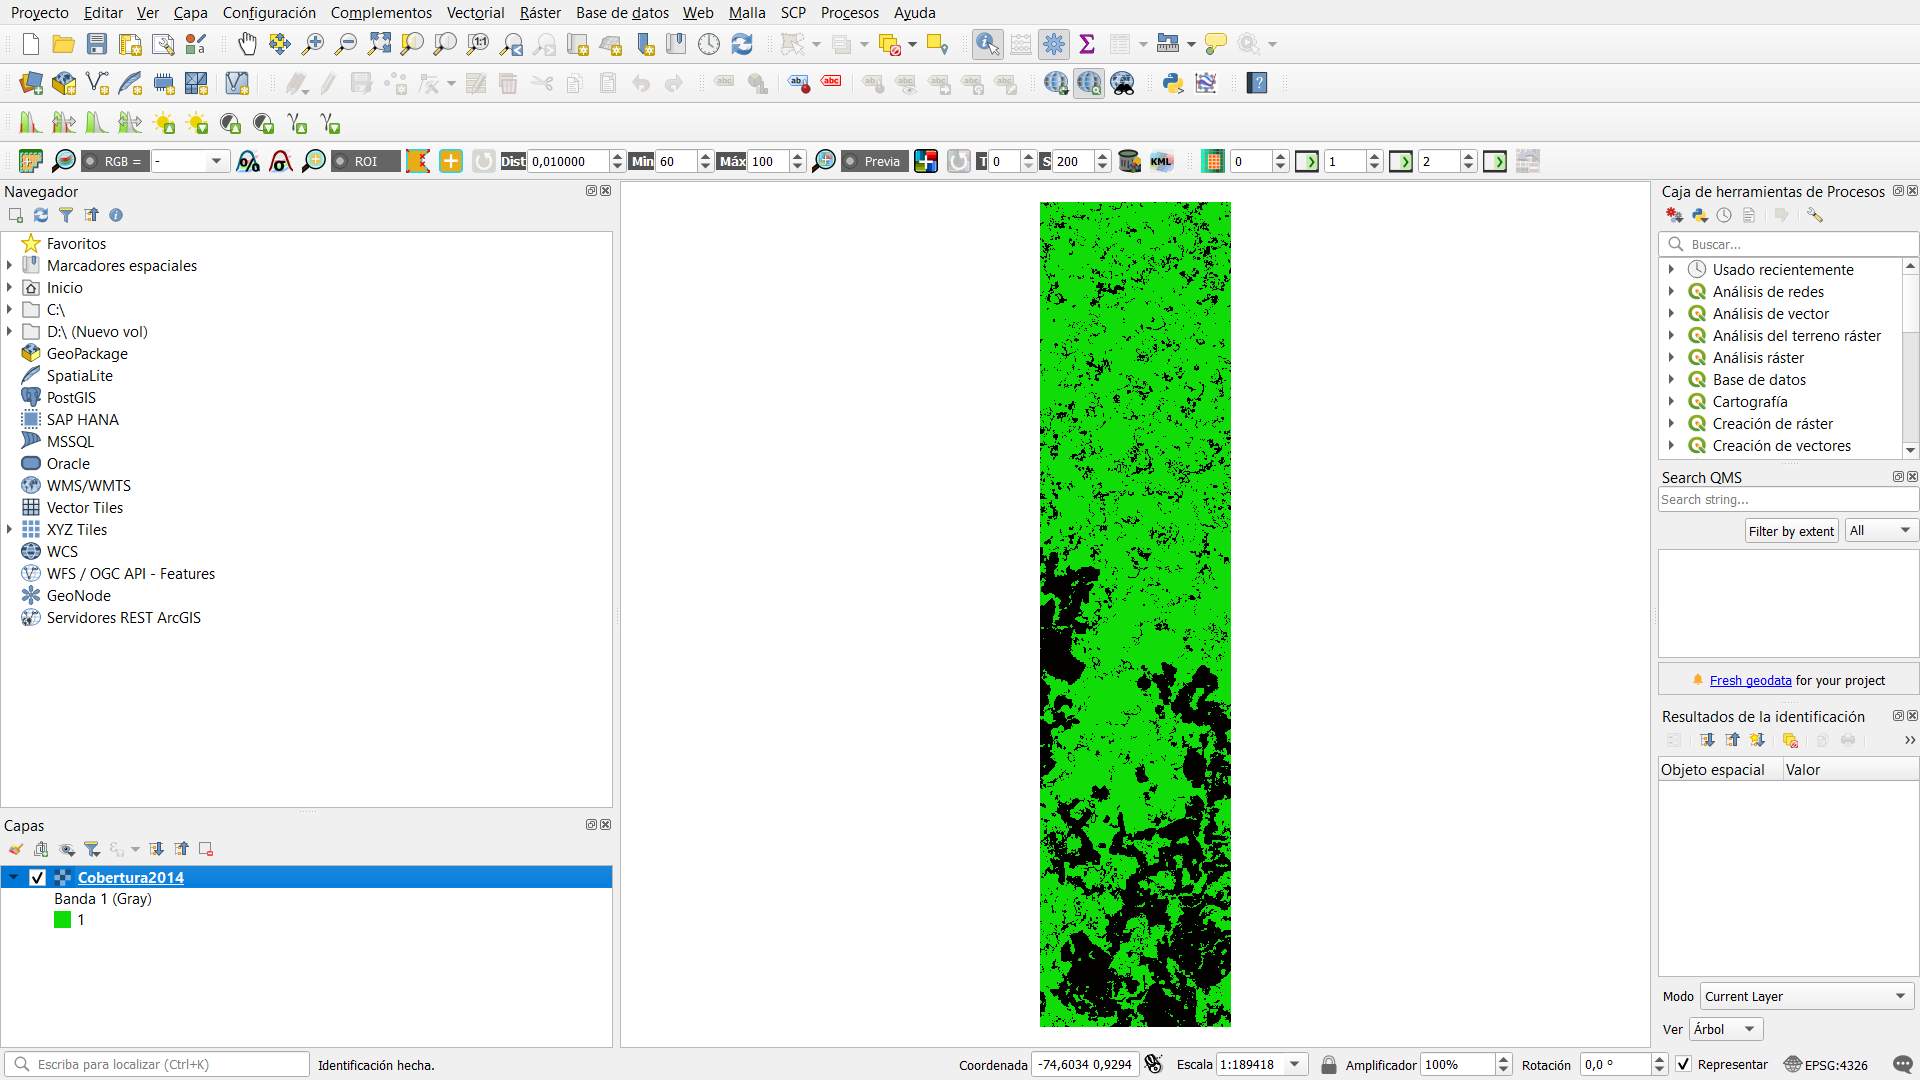

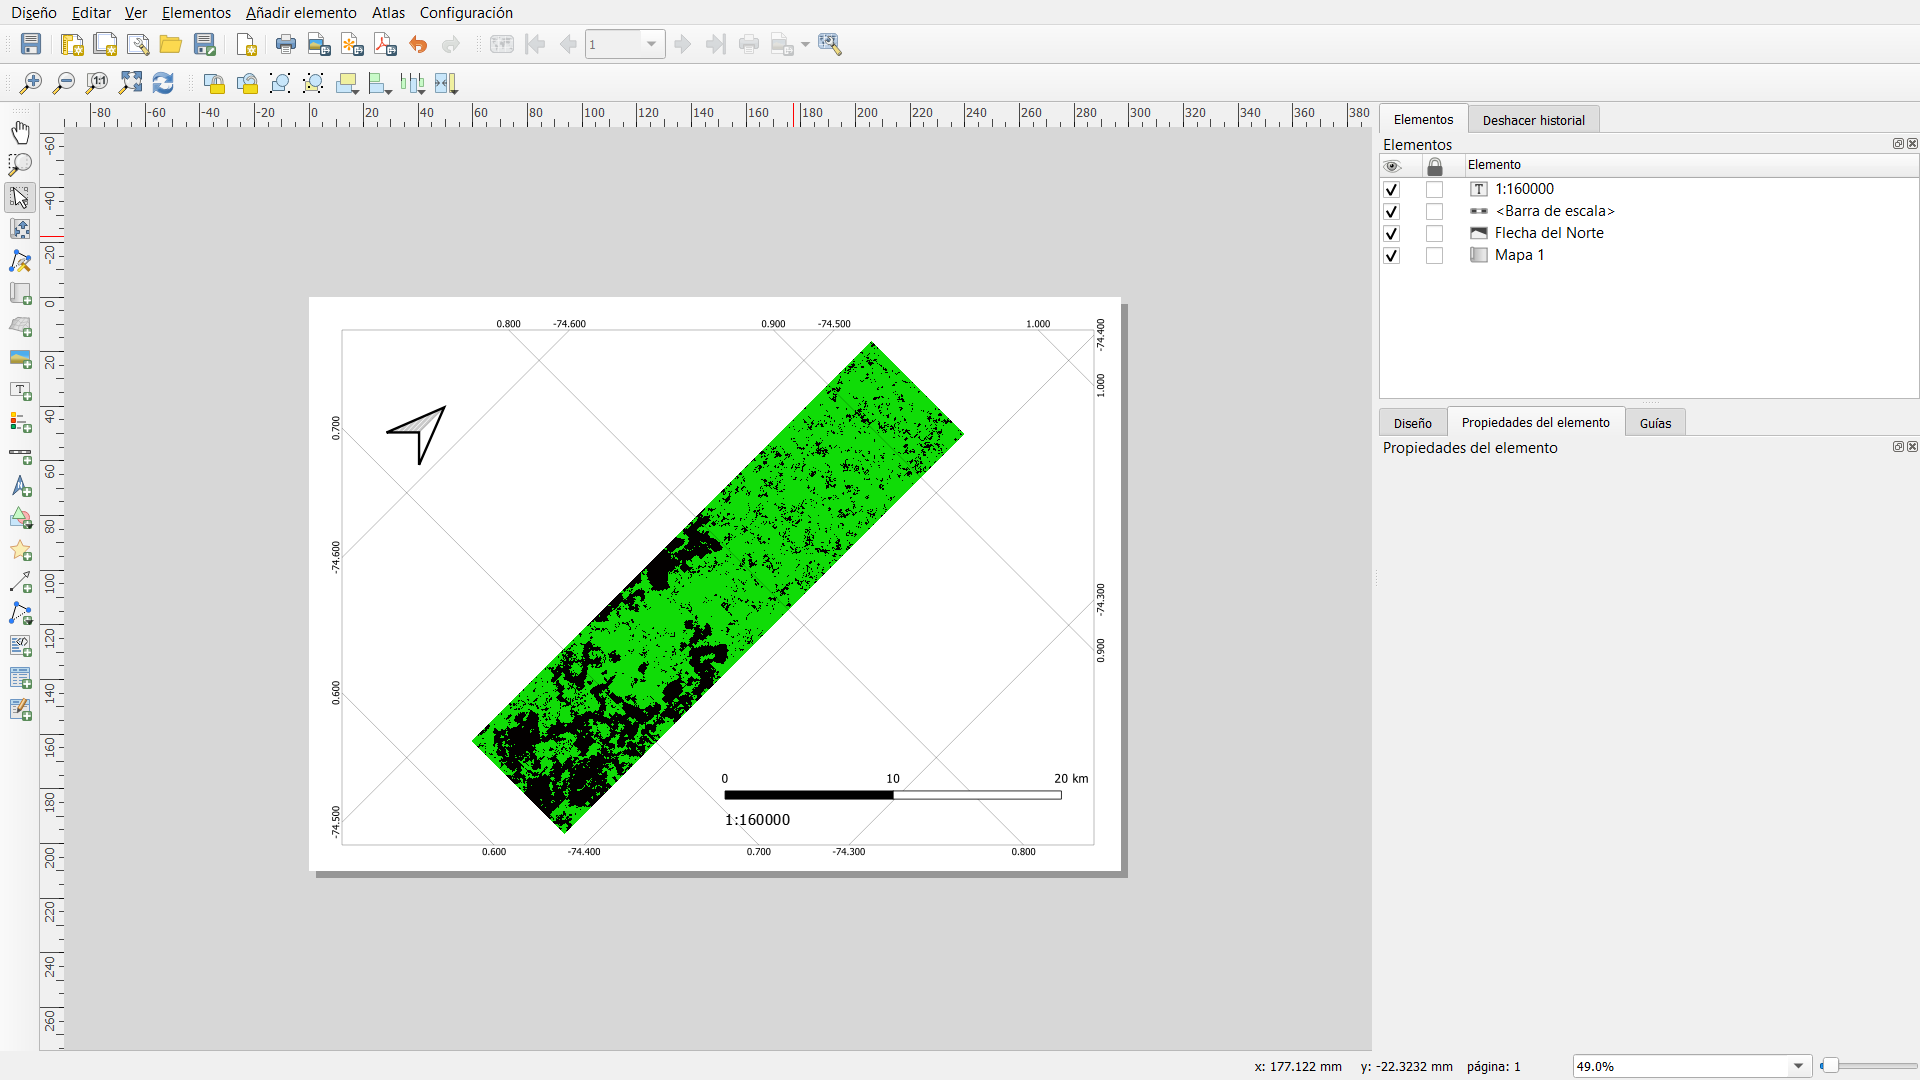